In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [2]:
os.listdir('./dataset/annotations/trimaps')[-5:]

['yorkshire_terrier_95.png',
 'yorkshire_terrier_96.png',
 'yorkshire_terrier_97.png',
 'yorkshire_terrier_98.png',
 'yorkshire_terrier_99.png']

In [3]:
img = tf.io.read_file('./dataset/annotations/trimaps/yorkshire_terrier_99.png')

In [4]:
img = tf.image.decode_png(img)

In [5]:
img.shape

TensorShape([358, 500, 1])

In [6]:
img = tf.squeeze(img)

In [7]:
img.shape

TensorShape([358, 500])

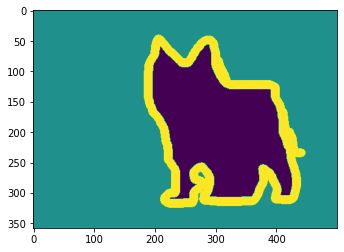

In [8]:
plt.imshow(img)

In [9]:
img

<tf.Tensor: shape=(358, 500), dtype=uint8, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)>

In [10]:
img.numpy().max()

3

In [11]:
img.numpy().min()

1

In [12]:
np.unique(img.numpy())

array([1, 2, 3], dtype=uint8)

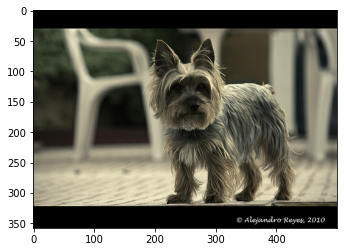

In [13]:
img = tf.io.read_file('./dataset/animal_images/yorkshire_terrier_99.jpg')
img = tf.image.decode_jpeg(img)
plt.imshow(img)

# 读取数据

In [14]:
images = glob.glob('./dataset/animal_images/*.jpg')

In [15]:
images[:3]

['./dataset/animal_images\\Abyssinian_1.jpg',
 './dataset/animal_images\\Abyssinian_10.jpg',
 './dataset/animal_images\\Abyssinian_100.jpg']

In [16]:
len(images)

7390

In [17]:
anno = glob.glob('./dataset/annotations/trimaps/*.png')

In [18]:
anno[:3]

['./dataset/annotations/trimaps\\Abyssinian_1.png',
 './dataset/annotations/trimaps\\Abyssinian_10.png',
 './dataset/annotations/trimaps\\Abyssinian_100.png']

In [19]:
len(anno)

7390

In [20]:
np.random.seed(2021)
#permutation:排列顺序
index = np.random.permutation(len(images))

In [21]:
#转换成array
images = np.array(images)[index]
anno = np.array(anno)[index]

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((images, anno))

In [23]:
test_count = int(len(images) * 0.2)
train_count = len(images) - test_count

In [24]:
test_count, train_count

(1478, 5912)

In [25]:
data_train = dataset.skip(test_count)
data_test = dataset.take(test_count)

In [26]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [27]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

In [28]:
def normal_img(input_images, input_anno):
    input_images = tf.cast(input_images, tf.float32)
    input_images = input_images / 127.5 -1
    #input_anno为[1,2,3]需要变为[0,1,2]
    input_anno -= 1
    return input_images, input_anno

In [29]:
@tf.function
def load_images(input_images_path, input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    input_image = tf.image.resize(input_image, (224, 224))
    input_anno = tf.image.resize(input_anno, (224, 224))
    return normal_img(input_image, input_anno)

In [30]:
data_train = data_train.map(load_images)

In [31]:
data_test = data_test.map(load_images)

In [32]:
BATCH_SIZE = 8

In [33]:
data_train = data_train.repeat().shuffle(100).batch(BATCH_SIZE)
data_test = data_test.batch(BATCH_SIZE)

In [34]:
data_train

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

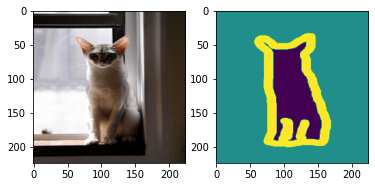

In [35]:
for img, anno in data_train.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))

In [36]:
conv_base = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape = (224, 224, 3),
    include_top = False
)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58892288/58889256 [==============================] - 29s 0us/step


In [37]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [38]:
# out_shape : 7*7*512 上采样 
#→ 14*14*512 然后与 block5_conv3相加
#→ 14*14*512 上采样
#→ 28*28*256 然后与 block4_conv3相加
#→ 28*28*256 上采样
#→ 56*56*128 然后与 block3_conv3相加 
#→ 56*56*128 上采样
#→ 112*112*64 然后block1_pool 相加 上采样
#→ 最终224*224*1 

# 如何获取中间层的方法

In [39]:
conv_base.get_layer('block5_conv3').output

<tf.Tensor 'block5_conv3/Identity:0' shape=(None, 14, 14, 512) dtype=float32>

In [40]:
#子模型,不要最后一层，继承conv_base的权重
sub_model = tf.keras.models.Model(
    inputs = conv_base.input,
    outputs = conv_base.get_layer('block5_conv3').output
)

In [41]:
sub_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [42]:
layer_names = [
    'block5_pool',
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
]

In [43]:
layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]

In [44]:
#创建多输出模型
multi_out_model= tf.keras.models.Model(
    inputs = conv_base.input,
    outputs = layers_output
)

In [45]:
multi_out_model.trainable = False

In [46]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
out, out_block5_conv3, out_block4_conv3 ,out_block3_conv3 = multi_out_model(inputs)

In [47]:
out.shape

TensorShape([None, 7, 7, 512])

In [48]:
out_block5_conv3.shape, out_block4_conv3.shape, out_block3_conv3.shape

(TensorShape([None, 14, 14, 512]),
 TensorShape([None, 28, 28, 512]),
 TensorShape([None, 56, 56, 256]))

In [49]:
x1 = tf.keras.layers.Conv2DTranspose(512, 3, 
                                     strides=2, 
                                     padding='same',
                                     activation='relu')(out)

In [50]:
x1.shape

TensorShape([None, 14, 14, 512])

In [51]:
x1 = tf.keras.layers.Conv2D(512, 3, 
                            padding='same',
                            activation='relu')(x1)

In [52]:
x1.shape

TensorShape([None, 14, 14, 512])

In [53]:
x2 = tf.add(x1, out_block5_conv3)

In [54]:
x2.shape

TensorShape([None, 14, 14, 512])

In [55]:
x2 = tf.keras.layers.Conv2DTranspose(512, 3, 
                                     strides=2, 
                                     padding='same',
                                     activation='relu')(x2)

In [56]:
x2.shape

TensorShape([None, 28, 28, 512])

In [57]:
x2 = tf.keras.layers.Conv2D(512, 3, 
                            padding='same',
                            activation='relu')(x2)
x2.shape

TensorShape([None, 28, 28, 512])

In [58]:
x3 = tf.add(x2, out_block4_conv3)
x3.shape

TensorShape([None, 28, 28, 512])

In [59]:
x3 = tf.keras.layers.Conv2DTranspose(256, 3, 
                                     strides=2, 
                                     padding='same',
                                     activation='relu')(x3)
x3.shape

TensorShape([None, 56, 56, 256])

In [60]:
x3 = tf.keras.layers.Conv2D(256, 3, 
                            padding='same',
                            activation='relu')(x3)
x3.shape

TensorShape([None, 56, 56, 256])

In [61]:
x4 = tf.add(x3, out_block3_conv3)
x4.shape

TensorShape([None, 56, 56, 256])

In [62]:
x5 = tf.keras.layers.Conv2DTranspose(128, 3, 
                                     strides=2, 
                                     padding='same',
                                     activation='relu')(x4)
x5.shape

TensorShape([None, 112, 112, 128])

In [63]:
x5 = tf.keras.layers.Conv2D(128, 3, 
                            padding='same',
                            activation='relu')(x5)
x5.shape

TensorShape([None, 112, 112, 128])

In [64]:
prediction = tf.keras.layers.Conv2DTranspose(3, 3,
                                             strides=2,
                                             padding='same',
                                             activation='softmax')(x5)
prediction.shape

TensorShape([None, 224, 224, 3])

In [65]:
model = tf.keras.models.Model(
    inputs = inputs,
    outputs = prediction
)

In [66]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 7, 7, 512),  14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 14, 14, 512)  2359808     model_1[1][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 512)  2359808     conv2d_transpose[0][0]           
____________________________________________________________________________________________

In [67]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc'])

In [68]:
model.fit(data_train,
          epochs=5,
          steps_per_epoch=train_count//BATCH_SIZE,
          validation_data=data_test,
          validation_steps=test_count//BATCH_SIZE
)

Train for 739 steps, validate for 184 steps
Epoch 1/5
739/739 [==============================] - 541s 732ms/step - loss: 0.3337 - acc: 0.8664 - val_loss: 0.2672 - val_acc: 0.8926
Epoch 2/5
739/739 [==============================] - 497s 673ms/step - loss: 0.2601 - acc: 0.8953 - val_loss: 0.2548 - val_acc: 0.8979
Epoch 3/5
739/739 [==============================] - 510s 689ms/step - loss: 0.2329 - acc: 0.9049 - val_loss: 0.2480 - val_acc: 0.9002
Epoch 4/5
739/739 [==============================] - 499s 675ms/step - loss: 0.2174 - acc: 0.9103 - val_loss: 0.2617 - val_acc: 0.8993
Epoch 5/5
739/739 [==============================] - 495s 669ms/step - loss: 0.2011 - acc: 0.9159 - val_loss: 0.2492 - val_acc: 0.9051


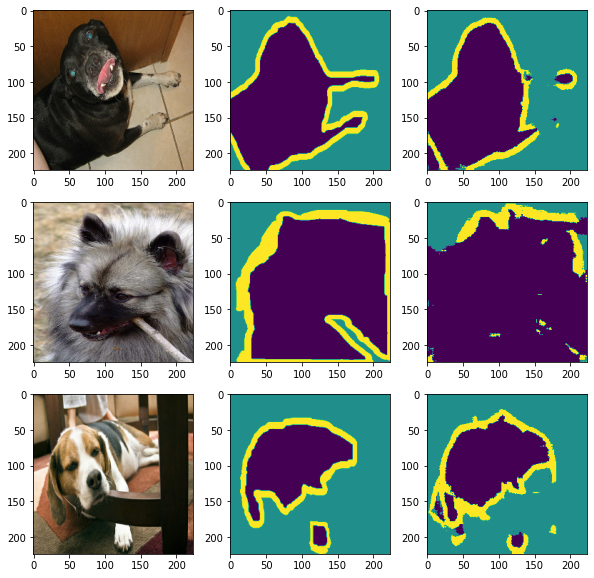

In [69]:
num = 3
for image, mask in data_test.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))